#### References
1. https://github.com/mhw32/variational-item-response-theory-public

In [1]:
import os
import pandas as pd
import numpy as np
from enum import Enum
import torch
from tqdm import tqdm
from torch import nn
from torch.nn import functional as F, init
from torch import optim
import torch.distributions as dist
import time
import shutil

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

torch.cuda.is_available()

True

In [2]:
ROOT_DIR = os.path.realpath('./')
DATA_DIR = os.path.join(ROOT_DIR, 'data')
EDNET_KT1_DIR = os.path.join(DATA_DIR, 'ednet_kt1')
OUT_DIR = os.path.join(ROOT_DIR, 'out')

In [3]:
MISSING_DATA = -1

# Data Exploration

In [4]:
def preprocess(dataset_file_name):
    cache_file = os.path.join(EDNET_KT1_DIR, dataset_file_name)
    if os.path.isfile(cache_file):
        return pd.read_csv(cache_file)
    
    responses = pd.read_csv(os.path.join(EDNET_KT1_DIR, f'unprocessed/{dataset_name}'))
    responses = responses[['timestamp', 'solving_id', 'question_id', 'user_answer', 'elapsed_time', 'user_id']]
    
    questions = pd.read_csv(os.path.join(EDNET_KT1_DIR, 'contents/questions.csv'))
    
    joined = pd.merge(responses, questions, how='inner', on=['question_id'])
    assert joined.shape[0] == responses.shape[0]
    
    joined.to_csv(cache_file, index=False)
    
    return joined

dataset_name = 'kt1_top_300_questions.csv'
raw_data = preprocess(dataset_name)
raw_data.head(2)

/home/lenar/miniconda3/envs/cs5228/lib/python3.7/site-packages/ipykernel_launcher.py:19: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.


,timestamp,solving_id,question_id,user_answer,elapsed_time,user_id,bundle_id,explanation_id,correct_answer,part,tags,deployed_at
0,1565096401774,5,q6528,b,59000,u1,b5060,e5060,d,5,90,1571281395009
1,1567979068913,275,q6528,c,77000,u1,b5060,e5060,d,5,90,1571281395009


In [5]:
raw_data = pd.read_csv(os.path.join(EDNET_KT1_DIR, dataset_name))
raw_data

/home/lenar/miniconda3/envs/cs5228/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,timestamp,solving_id,question_id,user_answer,elapsed_time,user_id,bundle_id,explanation_id,correct_answer,part,tags,deployed_at
0,1565096401774,5,q6528,b,59000,u1,b5060,e5060,d,5,90,1571281395009
1,1567979068913,275,q6528,c,77000,u1,b5060,e5060,d,5,90,1571281395009
2,1549164264780,6,q6528,a,40000,u1000,b5060,e5060,d,5,90,1571281395009
3,1518595345360,1614,q6528,d,42000,u100005,b5060,e5060,d,5,90,1571281395009
4,1567236293454,251,q6528,b,13000,u10001,b5060,e5060,d,5,90,1571281395009
...,...,...,...,...,...,...,...,...,...,...,...,...
17711266,1538362943067,7,q297,b,15000,u99615,b297,e297,b,2,24;40;183;184,1572412561072
17711267,1521105356470,1018,q297,a,15000,u99622,b297,e297,b,2,24;40;183;184,1572412561072
17711268,1516033596480,86,q297,b,15000,u99655,b297,e297,b,2,24;40;183;184,1572412561072
17711269,1542543279865,11,q297,b,18000,u9988,b297,e297,b,2,24;40;183;184,1572412561072


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17711271 entries, 0 to 17711270
Data columns (total 12 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   timestamp       int64 
 1   solving_id      int64 
 2   question_id     object
 3   user_answer     object
 4   elapsed_time    int64 
 5   user_id         object
 6   bundle_id       object
 7   explanation_id  object
 8   correct_answer  object
 9   part            int64 
 10  tags            object
 11  deployed_at     int64 
dtypes: int64(5), object(7)
memory usage: 1.6+ GB


In [7]:
print('The number of unique users:', len(raw_data['user_id'].unique()))
print('The number of unique questions:', len(raw_data['question_id'].unique()))

The number of unique users: 657058
The number of unique questions: 300


array([[<AxesSubplot:title={'center':'q_count'}>,
        <AxesSubplot:title={'center':'log_q_count'}>]], dtype=object)

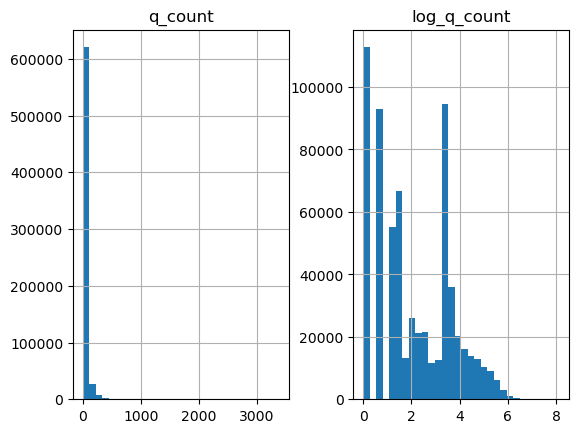

In [8]:
q_count_by_u = raw_data.groupby(['user_id'])['question_id'].count().reset_index()
q_count_by_u.columns = ['user_id', 'q_count']
q_count_by_u['log_q_count'] = np.log(q_count_by_u['q_count'])
q_count_by_u.hist(bins=30)

In [9]:
q_count_by_u.groupby('q_count')['user_id'].count().sort_values()

q_count
3381         1
661          1
665          1
668          1
673          1
         ...  
4        48639
3        55032
30       65200
2        92822
1       112734
Name: user_id, Length: 749, dtype: int64

In [10]:
# Whether a user answers the same question more than 1 time?
count_by_u_q = raw_data.groupby(['user_id', 'question_id'])['user_answer'].count().reset_index()
count_by_u_q.columns = ['user_id', 'question_id', 'count']

print('The number of unique (user_id, question_id):', count_by_u_q.shape[0])
print(count_by_u_q['count'].unique())

print('Insight: Multiple responses per (user_id, question_id).')

The number of unique (user_id, question_id): 15130790
[ 2  1  3  0  4  6  5  7  9  8 10 11 15 12 21 14 13 18 17 16 19 20 23 27
 28 22 53 29 48 51 30 62 49 54 46 38 41 39 36 31 47 24 43 52 42 26 55 44
 34 58 57 35 50 32 25 56 67]
Insight: Multiple responses per (user_id, question_id).


Insight: The visualization shows enough responses per question to learn unobserved question variables.


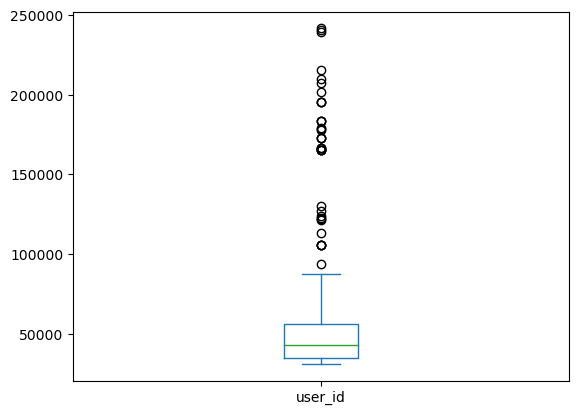

In [11]:
raw_data.groupby('question_id')['user_id'].count().plot(kind='box')
print('Insight: The visualization shows enough responses per question to learn unobserved question variables.')

In [12]:
raw_data['response'] = (raw_data['user_answer'] == raw_data['correct_answer'])
raw_data.groupby('response')['question_id'].count()

response
False    8523062
True     9188209
Name: question_id, dtype: int64

# Dataset Preparation

In [13]:
class EdnetKT1(torch.utils.data.Dataset):
    def __init__(self, ds_file='kt1_subset.csv', train=True, binarized_response=True, swap_ability_item=False, **kwargs):
        super().__init__()
        
        self.swap_ability_item = swap_ability_item
        
        name, _ = os.path.splitext(ds_file)
        raw_data = pd.read_csv(os.path.join(EDNET_KT1_DIR, ds_file))
        
        responses = self.make_score_matrix(raw_data, name=name)
        
        rs = np.random.RandomState(42)
        swapper = np.arange(responses.shape[0])
        rs.shuffle(swapper)
        responses = responses[swapper]
        
        self.binarized_response = binarized_response
        if binarized_response:
            responses = np.round(responses)
            
        num_users = responses.shape[0]
        num_train = int(0.7 * num_users)
        
        if train:
            responses = responses[:num_train]
        else:
            responses = responses[num_train:]
        
        response_mask = np.ones_like(responses)
        response_mask[responses == MISSING_DATA] = 0
 
        self.responses = responses
        self.mask = response_mask
        self.length = responses.shape[0]
        self.num_person = responses.shape[0]
        self.num_item = responses.shape[1]
    
    # From Trieu: Use Pandas vectorization to speed up the creation of the score matrix
    def make_score_matrix(self, raw_data, name):
        cache_file = os.path.join(EDNET_KT1_DIR, f'{name}_score_matrix_swap{self.swap_ability_item}.npy'.lower())
        if os.path.isfile(cache_file):
            return np.load(cache_file)
        
        raw_data['response'] = 0
        raw_data.loc[raw_data['user_answer'] == raw_data['correct_answer'], 'response'] = 1
        
        compact_score_mat = raw_data.groupby(['user_id', 'question_id'])['response'].mean().reset_index()
        score_mat = compact_score_mat.pivot(index='user_id', columns='question_id', values='response')
        score_mat = score_mat.fillna(MISSING_DATA)
        score_mat = score_mat.values
        
        if self.swap_ability_item:
            score_mat = np.transpose(score_mat)
                
        np.save(cache_file, score_mat)
        return score_mat
    
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        response = self.responses[index]
        item_id = np.arange(self.num_item)
        item_id[response == MISSING_DATA] = MISSING_DATA
        mask = self.mask[index]

        response = torch.from_numpy(response).float().unsqueeze(1)
        item_id = torch.from_numpy(item_id).long().unsqueeze(1)
        mask = torch.from_numpy(mask).bool().unsqueeze(1)

        return index, response, item_id, mask

In [14]:
import copy

def artificially_mask_dataset(old_dataset, perc):
    dataset = copy.deepcopy(old_dataset)
    assert perc >= 0 and perc <= 1
    response = dataset.responses
    mask = dataset.mask

    if np.ndim(mask) == 2:
        row, col = np.where(mask != 0)
    elif np.ndim(mask) == 3:
        row, col = np.where(mask[:, :, 0] != 0)
    pool = np.array(list(zip(row, col)))
    num_all = pool.shape[0]
    num = int(perc * num_all)
    
    rs = np.random.RandomState(42)
    indices = np.sort(
        rs.choice(np.arange(num_all), size=num, replace=False),
    )
    label_indices = pool[indices]
    labels = []
    for idx in label_indices:
        label = copy.deepcopy(response[idx[0], idx[1]])
        labels.append(label)
        mask[idx[0], idx[1]] = 0
        response[idx[0], idx[1]] = -1
    labels = np.array(labels)

    dataset.response = response
    dataset.mask = mask
    dataset.missing_labels = labels
    dataset.missing_indices = label_indices

    return dataset

# Implementation

## Configurations

In [15]:
irt_model = '1pl'           # Available values: '1pl', '2pl' and '3pl'
dataset = 'ednet-kt1'
ability_dim = 16
# From Trieu: Optional suggestion
# You can use deep-learning network to implement the decoding phase.
generative_model = 'irt'    # Available values: 'irt', 'link', 'deep', 'residual'

artificial_missing_perc = 0.3

num_person = len(raw_data['user_id'].unique()) * 0.7
num_item = len(raw_data['question_id'].unique())

lr = 5e-3
batch_size = 32
epochs = 5
max_iters = -1
num_workers = 0

cuda = True
gpu_device = 0

seed = 1221
torch.manual_seed(seed)
np.random.seed(seed)

## Model

In [16]:
def irt_model_1pl(ability, item_feat, return_logit = False):
    difficulty = item_feat
    logit = (torch.sum(ability, dim=1, keepdim=True) + difficulty.T).unsqueeze(2)

    if return_logit:
        return logit
    else:
        response_mu = torch.sigmoid(logit)
        return response_mu


def irt_model_2pl(ability, item_feat, return_logit = False):
    ability_dim = ability.size(1)
    discrimination = item_feat[:, :ability_dim]
    difficulty = item_feat[:, ability_dim:]
    logit = (torch.mm(ability, -discrimination.T) + difficulty.T).unsqueeze(2)
    
    if return_logit:
        return logit
    else:
        response_mu = torch.sigmoid(logit)
        return response_mu


def irt_model_3pl(ability, item_feat, return_logit = False):
    ability_dim = ability.size(1)
    discrimination = item_feat[:, :ability_dim]
    difficulty = item_feat[:, ability_dim:ability_dim+1]
    guess_logit = item_feat[:, ability_dim+1:ability_dim+2]
    guess = torch.sigmoid(guess_logit)
    logit = (torch.mm(ability, -discrimination.T) + difficulty.T).unsqueeze(2)
    
    if return_logit:
        return logit, guess
    else:
        guess = guess.unsqueeze(0)  
        response_mu = guess + (1. - guess) * torch.sigmoid(logit)
        return response_mu 

In [17]:
# MLE Classes

from torch.distributions.normal import Normal

class MLE_1PL(nn.Module):
    
    def __init__(
            self,
            latent_dim,
            num_person,
            num_item,
        ):
        super().__init__()

        self.latent_dim            = latent_dim
        self.ability_dim           = latent_dim
        self.response_dim          = 1
        self.num_person            = num_person
        self.num_item              = num_item

        self._set_item_feat_dim()

        self.ability = nn.Embedding(self.num_person, self.ability_dim)        
        self.item_feat = nn.Embedding(self.num_item, self.item_feat_dim)

        self.apply(self.weights_init)
        # From Trieu: Since weights_init initializes weights,
        # we should init ability and item_feat after it.
        self.ability.weight.data.normal_(0, 1)
        self.item_feat.weight.data.normal_(0, 1)

    def _set_item_feat_dim(self):
        self.item_feat_dim = 1

    def encode(self, index, response, mask):
        ability = self.ability(index)
        item_domain = torch.arange(self.num_item).unsqueeze(1).to(response.device)
        item_feat = self.item_feat(item_domain).squeeze(1)
        return ability, item_feat

    def decode(self, ability, item_feat):
        return irt_model_1pl(ability, item_feat)

    def forward(self, index, response, mask):
        ability, item_feat = self.encode(index, response, mask)
        response_mu = self.decode(ability, item_feat)
        return response_mu

    def log_likelihood(self, response_mu, response, mask):
        # From Trieu: We want to punish response, which is far away from the estimated response_mu
        #        so it is better to have smaller std = 0.1 instead of 1. This can be a hyperparameter to be tuned.
        #        We need to consider mask before calling sum
        #        because we do not want missing_responses contribute in the gradient computation graph.
        #        Otherwise, the model will learn to predict -1. Because -1 (missing) occupies significantly
        #        the response matrix, the model will have much higher tendency to predict 0 compared to 1.
        # return Normal(response_mu, 1).log_prob(response.squeeze(1)).sum()
        
        dist = torch.distributions.normal.Normal(response_mu, 0.1)
        log_prob = dist.log_prob(response)
        return log_prob * mask.float()

    def loss_fn(self, response_mu, response, mask):
        # From Trieu: response contains a batch of users, assuming that all users are independent of each other,
        #        it should be sum instead of mean.
        log_likelihood = self.log_likelihood(response_mu, response, mask).sum()
        log_posterior = log_likelihood
        return -log_posterior
    
    @staticmethod
    def weights_init(m):
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            init.xavier_normal_(m.weight.data, gain=init.calculate_gain('relu'))
            init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.BatchNorm1d):
            pass


class MLE_2PL(MLE_1PL):

    def _set_item_feat_dim(self):
        self.item_feat_dim = self.latent_dim + 1

    def decode(self, ability, item_feat):
        return irt_model_2pl(ability, item_feat)


class MLE_3PL(MLE_2PL):
    
    def _set_item_feat_dim(self):
        self.item_feat_dim = self.latent_dim + 2

    def decode(self, ability, item_feat):
        return irt_model_3pl(ability, item_feat)

In [18]:
out_file = 'MLE_{}_{}_{}person_{}item_{}maskperc_{}ability_seed{}'.format(
        irt_model, 
        dataset,
        num_person, 
        num_item,
        artificial_missing_perc,
        ability_dim, 
        seed,
    )

out_dir = os.path.join(OUT_DIR, out_file) 
    
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

device = torch.device("cuda" if cuda else "cpu")
if cuda: torch.cuda.set_device(gpu_device)

train_dataset = EdnetKT1(train=True, binarized_response=True, ds_file=dataset_name)
test_dataset  = EdnetKT1(train=False, binarized_response=True, ds_file=dataset_name)

if artificial_missing_perc > 0:
    train_dataset = artificially_mask_dataset(train_dataset, artificial_missing_perc)

num_person = train_dataset.num_person
num_item   = train_dataset.num_item

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size = batch_size, 
    shuffle = True,
    num_workers = num_workers,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size = batch_size, 
    shuffle = False,
    num_workers = num_workers,
)

N_mini_batches = len(train_loader)
if max_iters != -1:
    epochs = int(math.ceil(max_iters / float(len(train_loader))))
    print(f'Found MAX_ITERS={max_iters}, setting EPOCHS={epochs}') 

if irt_model == '1pl':
    model_class = MLE_1PL
elif irt_model == '2pl':
    model_class = MLE_2PL
elif irt_model == '3pl':
    model_class = MLE_3PL
else:
    raise Exception(f'model {irt_model} not recognized')

model = model_class(
    ability_dim,
    num_person,
    num_item,
).to(device)

/home/lenar/miniconda3/envs/cs5228/lib/python3.7/site-packages/ipykernel_launcher.py:19: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
/home/lenar/miniconda3/envs/cs5228/lib/python3.7/site-packages/ipykernel_launcher.py:20: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.


## Train

In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(state, is_best, folder='./', filename='checkpoint.pth.tar'):
    if not os.path.isdir(folder):
        os.makedirs(folder)
    torch.save(state, os.path.join(folder, filename))
    if is_best:
        shutil.copyfile(os.path.join(folder, filename),
                        os.path.join(folder, 'model_best.pth.tar'))

In [20]:
def train(epoch):
    model.train()
    train_loss = AverageMeter()
    pbar = tqdm(total=len(train_loader))

    for batch_idx, (index, response, _, mask) in enumerate(train_loader):
        mb = response.size(0)
        index = index.to(device)
        response = response.to(device)
        mask = mask.long().to(device)

        optimizer.zero_grad()

        # Forward pass
        response_mu = model.forward(index, response, mask)
        loss = model.loss_fn(response_mu, response, mask)

        loss.backward()
        optimizer.step()

        train_loss.update(loss.item(), mb)

        pbar.update()
        pbar.set_postfix({'Loss': train_loss.avg})

    pbar.close()
    print('====> Train Epoch: {} Loss: {:.4f}'.format(epoch, train_loss.avg))

    return train_loss.avg

def test(epoch):
    model.eval()
    test_loss = AverageMeter()
    pbar = tqdm(total=len(test_loader))

    with torch.no_grad():
        for index, response, _, mask in test_loader:       
            index = index.to(device)
            mb = response.size(0)
            response = response.to(device)
            mask = mask.long().to(device)
            
            mb = response.size(0)
            response = response.to(device)
            mask = mask.long().to(device)

            optimizer.zero_grad()

            # Forward pass
            response_mu = model.forward(index, response, mask)
            loss = model.loss_fn(response_mu, response, mask)
            
            test_loss.update(loss.item(), mb)

            pbar.update()
            pbar.set_postfix({'Loss': test_loss.avg})
            

    pbar.close()
    print('====> Test Epoch: {} Loss: {:.4f}'.format(epoch, test_loss.avg))

    return test_loss.avg

In [21]:
optimizer = optim.Adam(model.parameters(), lr=lr)

is_best, best_loss = False, np.inf
train_losses = np.zeros(epochs)
test_losses  = np.zeros(epochs)
train_times = np.zeros(epochs)

for epoch in range(epochs):
    start_time = time.time()
    train_loss = train(epoch)
    end_time = time.time()
    train_losses[epoch] = train_loss
    train_times[epoch] = start_time - end_time

    is_best = train_loss < best_loss
    best_loss = min(train_loss, best_loss)
    
    save_checkpoint({
        'model_state_dict': model.state_dict(),
        'epoch': epoch,
    }, is_best, folder=out_dir)

    np.save(os.path.join(out_dir, 'train_losses.npy'), train_losses)
    np.save(os.path.join(out_dir, 'train_times.npy'), train_times)
    np.save(os.path.join(out_dir, 'test_losses.npy'), test_losses)
        
print(f'Train time: {np.abs(train_times).sum()}')

100%|███████████████████████████████████████████████| 14374/14374 [01:55<00:00, 124.26it/s, Loss=7.96e+3]


====> Train Epoch: 0 Loss: 7956.6252


100%|███████████████████████████████████████████████| 14374/14374 [01:53<00:00, 126.21it/s, Loss=6.66e+3]


====> Train Epoch: 1 Loss: 6659.5326


100%|███████████████████████████████████████████████| 14374/14374 [01:57<00:00, 122.39it/s, Loss=5.86e+3]


====> Train Epoch: 2 Loss: 5857.2496


100%|███████████████████████████████████████████████| 14374/14374 [01:57<00:00, 121.94it/s, Loss=5.46e+3]


====> Train Epoch: 3 Loss: 5456.2782


100%|███████████████████████████████████████████████| 14374/14374 [01:58<00:00, 121.62it/s, Loss=5.35e+3]


====> Train Epoch: 4 Loss: 5353.3814
Train time: 583.0947778224945


## Inference

In [22]:
import numpy as np

In [23]:
def get_infer_dict(loader):
    model.eval()
    infer_dict = {}

    with torch.no_grad(): 
        
        abilities, item_feats, response_sample_set = [], [], []

        pbar = tqdm(total=len(loader))
        for index, response, _, mask in loader:
            mb = response.size(0)
            index = index.to(device)
            response = response.to(device)
            mask = mask.long().to(device)

            ability, item_feat = model.encode(index, response, mask)
            abilities.append(ability.cpu())
            item_feats.append(item_feat.cpu())
            
            response_sample_set.append(model.decode(ability, item_feat).cpu())

            pbar.update()
            
        abilities = torch.cat(abilities, dim=0)
        response_sample_set = torch.cat(response_sample_set, dim=0)
        
        pbar.close()

    end_time = time.time()

    return {'response': response_sample_set, 'infer_time': end_time - start_time, 'ability': abilities, 'item_feat': item_feats}

100%|█████████████████████████████████████████████████████████████| 14374/14374 [00:17<00:00, 844.30it/s]


y_pred: (array([0., 1.]), array([1620637, 1559777]))
y: (array([0., 1.]), array([1600342, 1580072]))
Missing Imputation Accuracy from samples: 0.6522675978661897
AUC: 0.70
[[1057523  542819]
 [ 563114 1016958]]
Infer time: 135.3630816936493


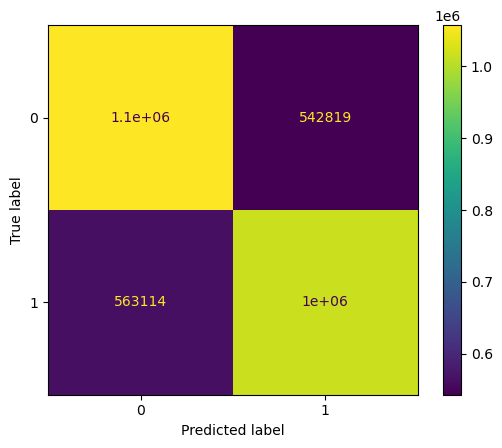

In [24]:
from sklearn.metrics import roc_auc_score

# From Trieu: The ability embedded vectors are learnt for users in the train dataset.
# Therefore, we cannot reuse these embeded vectors for users in the test dataset, because these are different users.
# We need to use artificial missing response to measure the trained model's performance.

def run_inference(train=True):
    dataset = train_dataset if train else test_dataset
    loader = torch.utils.data.DataLoader(
            dataset,
            batch_size = batch_size, 
            shuffle = False,
        )

    for checkpoint_name in [
        # 'checkpoint.pth.tar',
        'model_best.pth.tar'
    ]:
        checkpoint = torch.load(os.path.join(out_dir, checkpoint_name))
        model.load_state_dict(checkpoint['model_state_dict'])

        infer_dict = get_infer_dict(loader)
        checkpoint['infer_dict'] = infer_dict

        ability = infer_dict['ability']
        item_feat = infer_dict['item_feat']

        y_pred_prob = infer_dict['response']
        y_pred_prob = y_pred_prob.squeeze(2).numpy()
        y_pred = np.round(y_pred_prob)
        
        if artificial_missing_perc > 0:
            missing_indices = dataset.missing_indices
            missing_labels = dataset.missing_labels
            
            if np.ndim(missing_labels) == 1:
                missing_labels = np.round(missing_labels[:, np.newaxis])
                
            correct, count = 0, 0
            predicted_labels = []
            predicted_label_probs = []
            for missing_index, missing_label in zip(missing_indices, missing_labels):
                predicted_label = y_pred[missing_index[0], missing_index[1]]
                if predicted_label.item() == missing_label[0]:
                    correct += 1
                count += 1
                predicted_labels.append(predicted_label.item())
                predicted_label_probs.append(y_pred_prob[missing_index[0], missing_index[1]])
            
            print('y_pred:', np.unique(predicted_labels, return_counts=True))
            print('y:', np.unique(missing_labels.flatten(), return_counts=True))
            
            missing_imputation_accuracy = correct / float(count)
            checkpoint['missing_imputation_accuracy'] = missing_imputation_accuracy
            print(f'Missing Imputation Accuracy from samples: {missing_imputation_accuracy}')
            
            auc = roc_auc_score(missing_labels.flatten(), predicted_label_probs)
            print("AUC: {:.2f}".format(auc))
            
            cm = confusion_matrix(missing_labels.flatten(), predicted_labels)
            print(cm)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
            disp.plot()
            
            print(f'Infer time:', infer_dict['infer_time'])

run_inference()